# Example 2: Fingerpring molecules data and learning energy 

#### Huan Tran

The main objective of this example is to demonstrate a generic workflow of materials, involving (1) obtaining a small dataset of molecules and their energy, (2) fingerprint them, and (3) develop some ML models. 

### 1. Download a dataset
The dataset contains 10,000 non-equilibrium structures of CH$_3$-NH-OH molecules, whose energy was computed using BigDFT package and HGH norm-conserving pseudopotentials. It is available at www.matsml.org.

In [1]:
from matsml.data import Datasets
import pandas as pd
import os

# Load a dataset
dataset_name='molecs_CH3NHOH'
data=Datasets(dataset_name=dataset_name)
data.load_dataset()

# have a look at the content
print (pd.read_csv(os.path.join(os.getcwd(),str(dataset_name),'summary.csv')))

  matsML, version 1.0.0
  *****
  Load requested dataset(s)
    Data saved in molecs_CH3NHOH
              file_name      target
0     CH3NHOH_00001.xyz -940.288539
1     CH3NHOH_00002.xyz -940.580380
2     CH3NHOH_00003.xyz -940.184809
3     CH3NHOH_00004.xyz -940.460977
4     CH3NHOH_00005.xyz -940.579457
...                 ...         ...
9994  CH3NHOH_09996.xyz -940.286083
9995  CH3NHOH_09997.xyz -940.744461
9996  CH3NHOH_09998.xyz -940.553979
9997  CH3NHOH_09999.xyz -940.650902
9998  CH3NHOH_10000.xyz -940.059079

[9999 rows x 2 columns]


### 2. Fingerprint the obtained data
Two kinds of fingerprints will be demonstrated here

1. Coulomb matrix (CM) [M. Rupp, A. Tkatchenko, K.-R. Müller, and O. Anatole von Lilienfeld, <em>Fast and accurate modeling of molecular atomization energies with machine learning</em>, Phys. Rev. Lett., 108, 058301 (2012)] is perhaps one of the earliest fingerprints used in materials informatics. It was defined as an $N\times N$ matrix for a molecule of $N$ atoms. The key advantage of CM is that it is invariant under rotations and translations, required ro represent materials structure as a whole. However, its size depends on the molecule size, making it not directly usable for machine learning. Normally, the eigenvalues of these matricies are computed and sorted, and then zero padding is used to make fixed-size vectors. Here, we defined a projection of these Coulomb matricies onto a set of Gaussian functions, covering the entire range of the Coulomn matrix element values. The results are also a set of fixed-size fingerprints, which are ready for learning. Keyword for this fingerprint is __pcm_molecs__.

2. Smooth Overlap of Atomic Positions (SOAP) [S. De, A. P. Bartók, G. Csányi, and M. Ceriotti, <em>Comparing molecules and solids across structural and alchemical space</em>, Phys. Chem. Chem. Phys. __18__, 13754 (2016)] is a more sophisticated fingerprint. Keyword for this fingerprint is __soap_molecs__.

In [2]:
from matsml.fingerprint import Fingerprint

summary=os.path.join(os.getcwd(),'molecs_CH3NHOH/summary.csv')
data_loc=os.path.join(os.getcwd(),'molecs_CH3NHOH/')
n_atoms_max=8                          # max number of atoms in all of the structures to be fingerprinted
fp_dim=50                              # intended fingerprint dimensionality; the final number can be smaller 
verbosity=0                            # verbosity, 0 or 1
species=['C','H', 'N', 'O']            # All the spacies in the datasets, used for SOAP

#PCM
data_params_pcm={'fp_type':'pcm_molecs','summary':summary,'data_loc':data_loc,'n_atoms_max':n_atoms_max,
    'fp_file':'fp_pcm.csv','fp_dim':fp_dim,'species':species,'verbosity':verbosity}

fp_pcm=Fingerprint(data_params_pcm)
fp_pcm.get_fingerprint()

# SOAP
data_params_soap={'fp_type':'soap_molecs','summary':summary,'data_loc':data_loc,'species':species,
    'n_atoms_max':n_atoms_max,'fp_file':'fp_soap.csv','fp_dim':fp_dim,'verbosity':verbosity}

fp_soap=Fingerprint(data_params_soap)
fp_soap.get_fingerprint()

  Atomic structure fingerprinting
    summary                      /home/huan/work/matsml_examples/ex2_molecs/molecs_CH3NHOH/summary.csv
    data_loc                     /home/huan/work/matsml_examples/ex2_molecs/molecs_CH3NHOH/
    species                      ['C', 'H', 'N', 'O']
    fp_type                      pcm_molecs
    fp_file                      fp_pcm.csv
    fp_dim                       50
    n_atoms_max                  8
    verbosity                    0
  Read input
    num_structs                  9999
  Computing Coulomb matrix
    [==================================================] 100%
  Projecting Coulomb matrix to create fingerprints
    [==================================================] 100%
  Done fingerprinting, results saved in fp_pcm.csv
  Atomic structure fingerprinting
    summary                      /home/huan/work/matsml_examples/ex2_molecs/molecs_CH3NHOH/summary.csv
    data_loc                     /home/huan/work/matsml_examples/ex2_molecs/molecs

__The fingerprinting step is slow. A version of fingerprinted data can also be obtained in case you want to skip this step. Pandas can read gzip files fo no need to unzip them.__

In [3]:
from matsml.data import Datasets
import os

# Load data
data=Datasets(ds1='fp_molecs_CH3NHOH_pcm',ds2='fp_molecs_CH3NHOH_soap')
data.load_dataset()

print (os.path.isfile('fp_molecs_CH3NHOH_pcm.csv.gz'))
print (os.path.isfile('fp_molecs_CH3NHOH_soap.csv.gz'))

  Load requested dataset(s)
    Data saved in fp_molecs_CH3NHOH_pcm.csv.gz
    Data saved in fp_molecs_CH3NHOH_soap.csv.gz
True
True


### 3. Train some ML models with "fp_pcm.csv" and "fp_soap.csv" just created

In [4]:
# data parameters for learning

id_col=['id']             # column for data ID 
y_cols=['target']         # columns for (one or more) target properties
comment_cols=[]           # comment columns, anything not counted into ID, fingerprints, and target
n_trains=0.8              # 80% for training, 20% for validating
sampling='random'         # method for train/test spliting
x_scaling='minmax'        # method for x scaling
y_scaling='minmax'        # method for y scaling

# Dict of data parameters
data_params_pcm={'data_file':'fp_pcm.csv','id_col':id_col,'y_cols':y_cols,'comment_cols':comment_cols,
    'y_scaling':y_scaling,'x_scaling':x_scaling,'sampling':sampling,'n_trains':n_trains}

data_params_soap={'data_file':'fp_soap.csv','id_col':id_col,'y_cols':y_cols,'comment_cols':comment_cols,
    'y_scaling':y_scaling,'x_scaling':x_scaling,'sampling':sampling,'n_trains':n_trains}

 
  Learning fingerprinted/featured data
    algorithm                    fully connected NeuralNet w/ TensorFlow
    layers                       [8, 8, 8]
    activ_funct                  selu
    epochs                       200
    optimizer                    nadam
    nfold_cv                     5
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_pcm.csv
    data size                    9999
    training size                7999 (80.0 %)
    test size                    2000 (20.0 %)
    x dimensionality             30
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 FCNN
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.067107 0.076397 0.076397
    cv,rmse_train,rmse_t

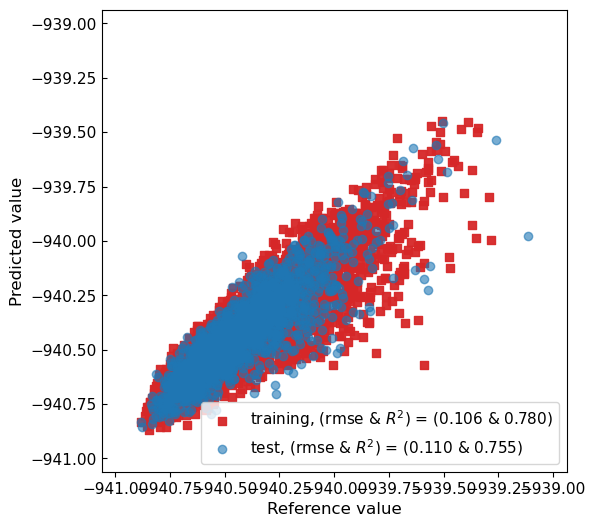

 
  Learning fingerprinted/featured data
    algorithm                    fully connected NeuralNet w/ TensorFlow
    layers                       [8, 8, 8]
    activ_funct                  selu
    epochs                       200
    optimizer                    nadam
    nfold_cv                     5
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_soap.csv
    data size                    9999
    training size                7999 (80.0 %)
    test size                    2000 (20.0 %)
    x dimensionality             1050
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 FCNN
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.031843 0.032226 0.032226
    cv,rmse_train,rms

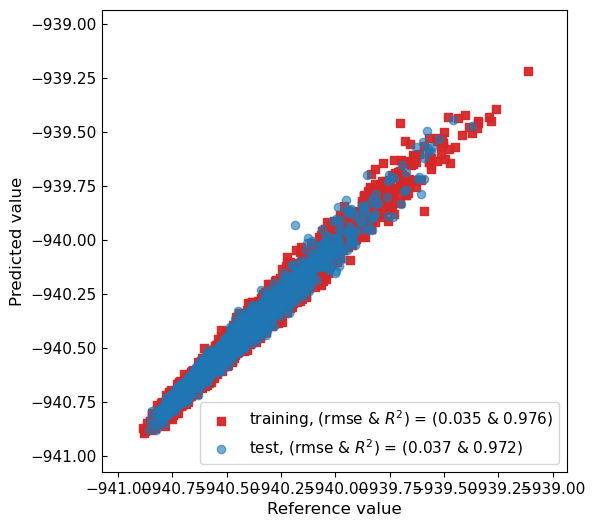

In [5]:
from matsml.models import FCNN

# Model parameters
layers=[8,8,8]               # list of nodes in hidden layers
epochs=200                   # Epochs
nfold_cv=5                   # Number of folds for cross validation
use_bias=True                # Use bias term or not
model_file='model_nn.pkl'    # Name of the model file to be created
verbosity=0                  # Verbosity, 0 or 1
batch_size=32                # Default = 32
loss='mse'
activ_funct='selu'           # Options: "tanh", "relu", and more
optimizer='nadam'            # Options: "Nadam", "Adam", and more

# Dict of model parameters
model_params={'layers':layers,'activ_funct':activ_funct,'epochs':epochs,'nfold_cv':nfold_cv,
    'optimizer':optimizer,'use_bias':use_bias,'model_file':model_file,'loss':loss,'batch_size':batch_size,
    'verbosity':verbosity,'rmse_cv':False}

# PCM
model=FCNN(data_params=data_params_pcm,model_params=model_params)
model.train()
model.plot(pdf_output=False)

#SOAP
model=FCNN(data_params=data_params_soap,model_params=model_params)
model.train()
model.plot(pdf_output=False)

### 4. The same flowwork with the CH$_4$ dataset

  Load requested dataset(s)
    Data saved in molecs_CH4
          file_name    target
0     CH4-00001.xyz -8.067843
1     CH4-00002.xyz -8.052410
2     CH4-00003.xyz -8.062879
3     CH4-00004.xyz -8.053809
4     CH4-00005.xyz -8.054724
...             ...       ...
9995  CH4-09996.xyz -8.061287
9996  CH4-09997.xyz -8.060672
9997  CH4-09998.xyz -8.013882
9998  CH4-09999.xyz -8.054027
9999  CH4-10000.xyz -8.052808

[10000 rows x 2 columns]
  Atomic structure fingerprinting
    summary                      /home/huan/work/matsml_examples/ex2_molecs/molecs_CH4/summary.csv
    data_loc                     /home/huan/work/matsml_examples/ex2_molecs/molecs_CH4/
    species                      ['C', 'H']
    fp_type                      pcm_molecs
    fp_file                      fp_CH4_pcm.csv
    fp_dim                       100
    n_atoms_max                  6
    verbosity                    0
  Read input
    num_structs                  10000
  Computing Coulomb matrix
    [=========

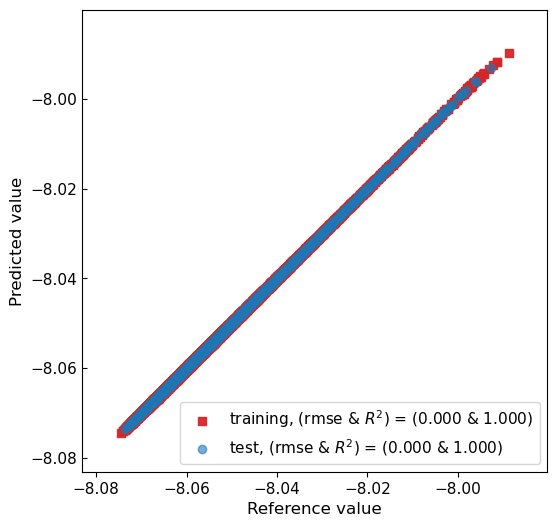

 
  Learning fingerprinted/featured data
    algorithm                    fully connected NeuralNet w/ TensorFlow
    layers                       [4, 4]
    activ_funct                  tanh
    epochs                       200
    optimizer                    nadam
    nfold_cv                     5
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_CH4_soap.csv
    data size                    10000
    training size                8000 (80.0 %)
    test size                    2000 (20.0 %)
    x dimensionality             275
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 FCNN
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.002920 0.003061 0.003061
    cv,rmse_train,rm

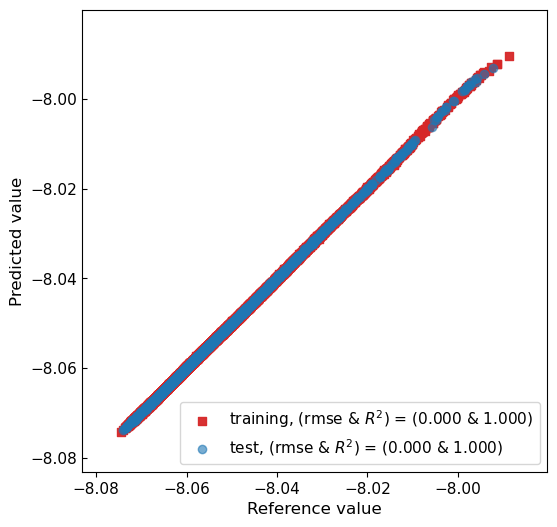

In [6]:
# Load data
data=Datasets(dataset_name='molecs_CH4')
data.load_dataset()
print (pd.read_csv('molecs_CH4/summary.csv'))

# Fingerprint
from matsml.fingerprint import Fingerprint
summary=os.path.join(os.getcwd(),'molecs_CH4/summary.csv')
data_loc=os.path.join(os.getcwd(),'molecs_CH4/')
n_atoms_max=6                          # max number of atoms in all of the structures to be fingerprinted
fp_type='pcm_molecs'                   # projected Coulomb matrix for molecules
fp_dim=100                             # intended fingerprint dimensionality; the final number can be smaller 
verbosity=0                            # verbosity, 0 or 1
species=['C','H']                      # All the spacies in the datasets, used for SOAP

# PCM
data_params_pcm={'fp_type':'pcm_molecs','summary':summary,'data_loc':data_loc,'n_atoms_max':n_atoms_max,
    'fp_file':'fp_CH4_pcm.csv','fp_dim':fp_dim,'species':species,'verbosity':verbosity}

fp_pcm=Fingerprint(data_params_pcm)
fp_pcm.get_fingerprint()

# SOAP
data_params_soap={'fp_type':'soap_molecs','summary':summary,'data_loc':data_loc,'species':species,
    'n_atoms_max':n_atoms_max,'fp_file':'fp_CH4_soap.csv','fp_dim':fp_dim,'verbosity':verbosity}

fp_soap=Fingerprint(data_params_soap)
fp_soap.get_fingerprint()


# Data params
id_col=['id']             # column for data ID 
y_cols=['target']         # columns for (one or more) target properties
comment_cols=[]           # comment columns, anything not counted into ID, fingerprints, and target
n_trains=0.8              # 80% for training, 20% for validating
sampling='random'         # method for train/test spliting
x_scaling='minmax'        # method for x scaling
y_scaling='minmax'        # method for y scaling

# Dict of data parameters
data_params_CH4_pcm={'data_file':'fp_CH4_pcm.csv','id_col':id_col,'y_cols':y_cols,'comment_cols':comment_cols,
    'y_scaling':y_scaling,'x_scaling':x_scaling,'sampling':sampling,'n_trains':n_trains}

data_params_CH4_soap={'data_file':'fp_CH4_soap.csv','id_col':id_col,'y_cols':y_cols,'comment_cols':comment_cols,
    'y_scaling':y_scaling,'x_scaling':x_scaling,'sampling':sampling,'n_trains':n_trains}


# Models with FCNN
from matsml.models import FCNN

# Model parameters
layers=[4,4]                 # list of nodes in hidden layers
epochs=200                   # Epochs
nfold_cv=5                   # Number of folds for cross validation
use_bias=True                # Use bias term or not
model_file='model_nn.pkl'    # Name of the model file to be created
verbosity=0                  # Verbosity, 0 or 1
batch_size=32                # Default = 32
loss='mse'
activ_funct='tanh'           # Options: "tanh", "relu", and more
optimizer='nadam'            # options: "Nadam", "Adam", and more

# Dict of model parameters
model_params={'layers':layers,'activ_funct':activ_funct,'epochs':epochs,'nfold_cv':nfold_cv,
    'optimizer':optimizer,'use_bias':use_bias,'model_file':model_file,'loss':loss,'batch_size':batch_size,
    'verbosity':verbosity,'rmse_cv':False}

# PCM
model=FCNN(data_params=data_params_CH4_pcm,model_params=model_params)
model.train()
model.plot(pdf_output=False)

#SOAP
model=FCNN(data_params=data_params_CH4_soap,model_params=model_params)
model.train()
model.plot(pdf_output=False)